In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import random
%matplotlib inline

In [2]:
#code written by us/ defining the points and visualizing the input data 
start_time = time.clock()
x = [0.4000, 0.2439, 0.1707, 0.2293, 0.5171, 0.8732, 0.6878, 0.8488, 0.6683, 0.6195]
y = [0.4439, 0.1463, 0.2293, 0.7610, 0.9414, 0.6536, 0.5219, 0.3609, 0.2536, 0.2634]

N = len(x) #Number of Cities

d = np.zeros([N,N]) # create a matrix with NxN martix

for i in range(N):
    for j in range(N):
        d[i, j]=np.sqrt(pow(x[i]-x[j],2)+pow(y[i]-y[j],2)) #Euclidean distance Matrix
        
#plt.plot(x, y, '-o')

c:\users\deep_hp\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


In [3]:
# Calcualting the desired distance/ code written by us
d1 = np.zeros([N])
for i in range(N-1):
    d1[i]=np.sqrt((x[i]-x[i+1])**2+(y[i]-y[i+1])**2)

h=sum(d1)
h=h+np.sqrt((x[N-1]-x[0])**2+(y[N-1]-y[0])**2)
print(round(h))

3


In [4]:
# Parameters for network energy function / tuning the hyperparameter
A=500; B=500; C=1000; D=500; alpha=0.01

In [5]:
#network build and contraints taken from github with some minor changes
# x-v-value of each node, y-u-input potential, u0-gamma
def hopfield():
    u0=0.02
    toend=0
    udao=np.zeros([N, N])
    ctr=0
    while toend==0:
        ctr+=1
        # U initialization
        v = np.random.rand(N,N)
        u = np.ones([N, N])*(-u0*np.log(N-1)/2)
        u+=u*0.91
        for _ in range(1000):
            for vx in range(N):
                for vi in range(N):
                    j1,j2,j3,j4=0,0,0,0
                    # Constraint 1 (sum over columns j!=vi)
                    for j in range(N):
                        if j!=vi:
                            j1+=v[vx, j]
                            #print(j, vi, j1)
                    j1*=-A
                    # contraint 2 (sum over rows y!=x)
                    for y in range(N):
                        if y!=vx:
                            j2+=v[y, vi]
                    j2*=-B
                    # constraint 3 (overall sum)
                    j3 = np.sum(v)
                    j3=-C*(j3-N)

                    # Shortest distance contraint 
                    for y in range(N):
                        if y!=vx:
                            if vi==0:
                                j4+=d[vx, y]*(v[y, vi+1]+v[y, N-1])
                            elif vi==N-1:
                                j4+=d[vx, y]*(v[y, vi-1]+v[y, 0])
                            else:
                                j4+=d[vx, y]*(v[y, vi+1]+v[y, vi-1])
                    j4*=-D
                    udao[vx, vi]= -u[vx, vi]+j1+j2+j3+j4
            # update status and derivatives
            u=u+alpha*udao
            # calculate node value from input potential u
            v=(1+np.tanh(u/u0))/2
            # threshold
            for vx in range(N):
                for vi in range(N):
                    if(v[vx, vi]<0.3):
                        v[vx, vi]=0
                    if(v[vx, vi]>0.7):
                        v[vx, vi]=1
        # testing whether solution is legal
        t1, t2, t3 = 0, 0, 0
        # require total of N-nodes with 1 value
        t1=0;
        for vx in range(N):
            for vi in range(N):
                t1+=v[vx, vi]
        # allow only one node in each row equal 1
        t2=0
        for x in range(N):
            for i in range(N-1):
                for j in range(i+1, N):
                    t2+=np.multiply(v[x, i], v[x, j])
        # allow only one node in each column equal 1
        t3=0
        for i in range(N):
            for x in range(N-1):
                for y in range(x+1, N):
                    t3+=np.multiply(v[x, i], v[y, i])
        # stop the loop after getting the valid solution
        if t1==N and t2==0 and t3==0:
            toend = 1
        else:
            toend = 0
    return(v, ctr)

In [6]:
# calculting the paht cost based on the updated distanvce matrix for each iteration
def path_cost(v):
    x_des = np.zeros([N+1])
    y_des = np.zeros([N+1])
    for j in range(N):
        for i in range(N):
            if v[i,j]==1:
                x_des[j]=x[i]
                y_des[j]=y[i]

    x_des[N]=x_des[0]
    y_des[N]=y_des[0]
    # calculate the total distance
    total_dis=0
    for i in range(N-1):
        total_dis+=np.sqrt((x_des[i]-x_des[i+1])**2+(y_des[i]-y_des[i+1])**2)
    total_dis+=np.sqrt((x_des[N-1]-x_des[0])**2+(y_des[N-1]-y_des[0])**2)
    return(total_dis, x_des, y_des)

In [7]:
# defining the desired city sequence
v_ideal = np.zeros([N,N])
seq=[0, 3, 4, 5, 6, 7, 8, 9, 1, 2] #assuming this as ideal route based on the co-ordinates
j=0
for el in seq:
    v_ideal[el, j]=1 # Based on the sequence assumed above the distance matrix is obtained
    j+=1

In [8]:
v = np.zeros([N,N])
# desired total distance taken from the euclidean distance matrix
des_td = round(h,4)
count=0
node_list = [] #creating an array where the obtained distance matrix is temporarily stored and updated after each iteration
while True:
    count+=1
    v, steps = hopfield() #calling the network
    td, _, _ = path_cost(v)
    if np.array_equiv(v, v_ideal):
        print("Desired city sequence matrix and distance achieved for {} runs".format(count))
        print(v)
        print("Distance: ", td)
        node_list.append(v)
        break
    elif td<=des_td:
        print("Achieved desired distance for {} runs".format(count))
        print(v)
        print(td)
        node_list.append(v)
    else:
        print("No desired solution, executed for {} steps, total distance {}".format(steps, td))

No desired solution, executed for 4 steps, total distance 3.3979861478331537
No desired solution, executed for 2 steps, total distance 3.151553187787153
No desired solution, executed for 2 steps, total distance 3.289386459807838
No desired solution, executed for 3 steps, total distance 3.051772888323607
Achieved desired distance for 5 runs
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
2.7693317173730323
No desired solution, executed for 2 steps, total distance 3.07688403723284
No desired solution, executed for 4 steps, total distance 3.3977461806169043
No desired solution, executed for 4 steps, total distance 3.2302961726790116
No desired solution, executed for 1 steps, total distance 3.323956675582881
Ach

Achieved desired distance for 73 runs
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
2.751737575763469
No desired solution, executed for 1 steps, total distance 3.1437871562524933
Achieved desired distance for 75 runs
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]
2.751737575763469
No desired solution, executed for 1 steps, total distance 3.454499649039991
Achieved desired distance for 77 runs
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [

No desired solution, executed for 4 steps, total distance 3.5805454031870596
Achieved desired distance for 116 runs
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]
2.6906706370094136
No desired solution, executed for 3 steps, total distance 2.898195562065075
Achieved desired distance for 118 runs
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
2.6906706370094136
No desired solution, executed for 1 steps, total distance 3.591768723

No desired solution, executed for 1 steps, total distance 2.8392822261223336
Achieved desired distance for 175 runs
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
2.7693317173730323
No desired solution, executed for 4 steps, total distance 4.501731197871755
Achieved desired distance for 177 runs
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
2.751737575763469
No desired solution, executed for 1 steps, total distance 3.4761819509

No desired solution, executed for 2 steps, total distance 2.917681516833086
Achieved desired distance for 217 runs
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
2.6906706370094136
Achieved desired distance for 218 runs
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
2.690670637009414
Achieved desired distance for 219 runs
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0

No desired solution, executed for 2 steps, total distance 3.08296289091303
Achieved desired distance for 271 runs
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
2.774177443030279
No desired solution, executed for 1 steps, total distance 3.5370848686239174
No desired solution, executed for 2 steps, total distance 2.931383753843156
No desired solution, executed for 1 steps, total distance 3.250971617092578
No desired solution, executed for 5 steps, total distance 2.9787611729186545
No desired solution, executed for 3 steps, total distance 3.2066192757032765
Achieved desired distance for 277 runs
[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0.

No desired solution, executed for 7 steps, total distance 3.5548430312849173
No desired solution, executed for 2 steps, total distance 2.984704578491594
No desired solution, executed for 7 steps, total distance 3.3640168966477866
No desired solution, executed for 3 steps, total distance 3.0908516504445323
No desired solution, executed for 2 steps, total distance 2.858679363188962
Achieved desired distance for 334 runs
[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
2.7517375757634683
Achieved desired distance for 335 runs
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0

Achieved desired distance for 397 runs
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]
2.6906706370094136
No desired solution, executed for 7 steps, total distance 3.8745904491934198
No desired solution, executed for 3 steps, total distance 3.7480152975923895
No desired solution, executed for 1 steps, total distance 3.7529627661941887
No desired solution, executed for 6 steps, total distance 3.019581554138139
No desired solution, executed for 1 steps, total distance 3.4862294843049537
No desired solution, executed for 11 steps, total distance 3.088177781476484
No desired solution, executed for 7 steps, total distance 3.0255249597110785
No desired solution, executed for 2 steps, total distance 2.9844365065729

No desired solution, executed for 2 steps, total distance 2.8303986561270875
No desired solution, executed for 1 steps, total distance 2.923217917807872
No desired solution, executed for 1 steps, total distance 2.7782152873682784
Achieved desired distance for 459 runs
[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]
2.7693317173730323
No desired solution, executed for 4 steps, total distance 3.2885412315446607
No desired solution, executed for 1 steps, total distance 2.8303986561270875
Achieved desired distance for 462 runs
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 

Achieved desired distance for 501 runs
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
2.690670637009414
Achieved desired distance for 502 runs
[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]
2.7741774430302786
No desired solution, executed for 2 steps, total distance 2.778215287368279
No desired solution, executed for 6 steps, total distance 3.3554367495833866
No desired solution, executed for 6 steps, total distance 3.7713643482

Achieved desired distance for 555 runs
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
2.6906706370094136
Achieved desired distance for 556 runs
[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
2.6906706370094136
No desired solution, executed for 1 steps, total distance 3.2588422559804924
No desired solution, executed for 3 steps, total distance 3.1515531877871528
No desired solution, executed for 3 steps, total distance 3.42995130

Achieved desired distance for 605 runs
[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]
2.690670637009414
No desired solution, executed for 1 steps, total distance 3.1113633236274296
Achieved desired distance for 607 runs
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
2.751737575763469
No desired solution, executed for 1 steps, total distance 3.19868019095167
No desired solution, executed for 1 steps, total distance 2.830398656127

Achieved desired distance for 656 runs
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
2.751737575763469
No desired solution, executed for 4 steps, total distance 3.3710534268222703
No desired solution, executed for 7 steps, total distance 3.2479215603932996
No desired solution, executed for 1 steps, total distance 2.974070178644536
No desired solution, executed for 11 steps, total distance 3.2301144482052186
No desired solution, executed for 1 steps, total distance 3.277085100057847
No desired solution, executed for 3 steps, total distance 2.898195562065075
No desired solution, executed for 1 steps, total distance 3.015885674001839
No desired solution, executed for 1 steps, total distance 3.018928404202021


In [9]:
#creating a function which an represnt the route as shown 
def route_representation(v):
    route = ""
    for j in range(v.shape[1]):
        route += str(np.argmax(v[:, j])) + '->'
    return (route + str(np.argmax(v[:, 0])))

In [10]:
def label(N, x, y):
    labels = np.arange(10) #for the plot generated from the 0btained route the labels for that particular plot is created using references
    for label, x, y in zip(labels, x, y):
        plt.annotate(
            label,
            xy=(x, y), xytext=(-20, 20),
            textcoords='offset points', ha='right', va='bottom',
            bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.5),
            arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

Total distance:  2.7693317173730323
Given city sequence: 0->3->4->5->6->7->8->9->1->2->0
Obtained city sequence: 3->4->5->6->7->8->9->2->1->0->3


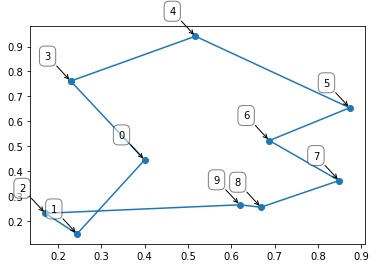

In [11]:
v = node_list[0]
td, X, Y = path_cost(v)
print("Total distance: ", td)
plt.plot(X, Y,'o-');
label(N, x, y)
print("Given city sequence: {}".format(route_representation(v_ideal)))
print("Obtained city sequence: {}".format(route_representation(v)))

In [12]:
print((time.clock() - start_time)/60, "Minutes")

119.96081545666667 Minutes


c:\users\deep_hp\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.


In [25]:
def route_rep(v):
    route = []
    for j in range(v.shape[1]):
        route.append(str(np.argmax(v[:, j])))
        print(str(np.argmax(v[:, j])))

In [26]:
print(route_rep(v_ideal))

0
3
4
5
6
7
8
9
1
2
None
